[View in Colaboratory](https://colab.research.google.com/github/msalihs/COMP-551-Project-1/blob/master/Demo.ipynb)

# ASSIGNMENT 4 - TRACK 3 

## Policy Gradient with Traces

## Problem Statement
Implement the algorithm shown in the box “Actor-Critic with Eligibility Traces” on page 275 of S&B in an environment of your choice. Compare this algorithm with the following two variants:
1. with only a trace on the critic but not the actor
2. without any trace using one-step returns

Report on the effect of gamma and lambda.



## Implementation


### Algorithm 

The algorithm in question from S&B book page 275 - Actor-Critic algorithm with Eligibility traces is given below;

![alt text](https://preview.ibb.co/iNrB77/Algorithm.png)


### Environment
As the environment, I chose to use Frozen Lake problem from OpenAI Gym. It's a basic algorithmic environment and it works well in the context of a Web-based Python notebook, such as Google Colab. 

In a nutshell, the agent controls the movement in a grid world where only some of the tiles are walkable, and others are not. The agent is rewarded for finding a walkable path to a goal tile.

For more information on FrozenLakeEnv see [here](https://gym.openai.com/envs/FrozenLake-v0/).

### Architecture

The policy estimator $\pi(a|s,\theta)$ and state-value function estimator $\hat{v}(s,w)$ are designed as 2 layer neural networks. 

Tenserflow is used for the implementation. Being a quite versatile programming language, it allows for a lot of configuration while handling all the backpropagation and training of the network. 

After a brief hyper-parameter tuning, the hidden layer sizes are chosen to be 200 for the first layer and 100 for the second layer for both of the neural-nets. 

## Required packages

First installing gym and opengl. This is only necessary if it is being run from Google Colab as these libraries are not installed by default and might be needed to re-install whenever a new instance is created. 

In [1]:
!pip install gym
!apt-get install python-opengl

    100% |████████████████████████████████| 1.5MB 809kB/s 
    100% |████████████████████████████████| 1.0MB 1.3MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/f8/88/f2/22e53080a462567706fad31295462941b3b06b16b51c3ab3e1
Successfully built gym
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libdrm2 libelf1 libgl1-mesa-dri libgl1-mesa-glx libglapi-mesa
  libglu1-mesa libllvm5.0 libpciaccess0 libsensors4 libtxc-dxtn-s2tc
  libx11-xcb1 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0
  libxcb-sync1 libxdamage1 libxfixes3 libxi6 libxshmfence1 libxxf86vm1
Suggested packages:
  pciutils lm-sensors python-tk python-numpy libgle3
The following NEW packages will be installed:
  freeglut3 libdrm-amdgpu1 libdrm-common libdrm-intel1 li

Selecting previously unselected package libxshmfence1:amd64.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-libxshmfence1_1.2-1_amd64.deb ...
Unpacking libxshmfence1:amd64 (1.2-1) ...
Selecting previously unselected package libxxf86vm1:amd64.
Preparing to unpack .../01-libxxf86vm1_1%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86vm1:amd64 (1:1.1.4-1) ...
Selecting previously unselected package libelf1:amd64.
Preparing to unpack .../02-libelf1_0.170-0.1_amd64.deb ...
Unpacking libelf1:amd64 (0.170-0.1) ...
Selecting previously unselected package libdrm-common.
Preparing to unpack .../03-libdrm-common_2.4.83-1_all.deb ...
Unpacking libdrm-common (2.4.83-1) ...
Selecting previously unselected package libdrm2:amd64.
Preparing to unpack .../04-libdrm2_2.4.83-1_amd64.deb ...
Unpacking libdrm2:amd64 (2.4.83-1) ...
Selecting previously unselected package libglapi-mesa:amd64.
Preparing to unpack .../05-libglapi-mesa_17.2.8-0ubuntu0~17.10.1_amd64.de

Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libelf1:amd64 (0.170-0.1) ...
Setting up libxshmfence1:amd64 (1.2-1) ...
Setting up libllvm5.0:amd64 (1:5.0-3) ...
Setting up libtxc-dxtn-s2tc:amd64 (1.0+git20151227-2) ...
update-alternatives: using /usr/lib/x86_64-linux-gnu/s2tc/libtxc_dxtn.so to provide /usr/lib/x86_64-linux-gnu/libtxc_dxtn.so (libtxc-dxtn-x86_64-linux-gnu) in auto mode
Setting up libglapi-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libdrm-common (2.4.83-1) ...
Setting up libxcb-sync1:amd64 (1.12-1ubuntu1) ...
Setting up libx11-xcb1:amd64 (2:1.6.4-3) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libpciaccess0:amd64 (0.13.4-1ubuntu1) ...
Setting up libsensors4:amd64 (1:3.4.0-4) ...
Setting up libxxf86vm1:amd64 (1:1.1.4-1) ...
Setting up libdrm2:amd64 (2.4.83-1) ...
Setting up libdrm-intel1:amd64 (2.4.83-1) ...
Setting up libdrm-radeon1:amd64 (2.4.83-1) ...
Setting up libdrm-nouveau2:amd6

## Code

Following function implements the whole actor-critic network. This is not the best way to do it, but works well in the context of a self-contained Python notebook.

In [0]:
import gym
from gym.envs.registration import register, spec
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

def actor_critic(epochs=1000, gamma = 0.9, lamda = 0.3, lrc = 0.001, lra = 0.0001, useETforA=False, useETforC=False, verbose=True):
    tf.reset_default_graph()
    with tf.Session() as sess:
        # Get the environment, and seed with the same so that results are comparable
        env = gym.make('FrozenLake-v0')
        env.seed(1)        
        numOfStates = env.observation_space.n
        numOfActions = env.action_space.n
        
        fl = 200
        sl = 100
        # Create the Actor Network - 2 layers 200 first layer + 100 second layer + 16 output states
        with tf.variable_scope("Actor"):
            inputsA = tf.placeholder(tf.float32, shape=[None, numOfStates])
            # Layer 1 
            w1a =  tf.get_variable("w1a", shape=[numOfStates,fl], initializer=tf.contrib.layers.xavier_initializer(seed=1))
            b1a = tf.Variable(tf.zeros([fl]))
            z1a = tf.matmul(inputsA,w1a)+b1a
            l1a = tf.nn.tanh(z1a)
            # Layer 2            
            w2a =  tf.get_variable("w2a", shape=[fl,sl], initializer=tf.contrib.layers.xavier_initializer(seed=1))
            b2a = tf.Variable(tf.zeros([sl]))
            z2a = tf.matmul(l1a,w2a)+b2a
            l2a = tf.nn.tanh(z2a)
            #output layer
            w3a = tf.get_variable("w3a", shape=[sl,numOfActions], initializer=tf.contrib.layers.xavier_initializer(seed=1))
            b3a = tf.Variable(tf.zeros([numOfActions]))
            z3a = tf.matmul(l2a,w3a) + b3a
            actorOutput = tf.squeeze(tf.nn.softmax(z3a))
            
            actorTdError = tf.placeholder(dtype=tf.float32)
            actorActionHist = tf.placeholder(dtype=tf.int64)
            actorPickedActionProb = tf.gather(actorOutput, actorActionHist)
            actorLossFcn = -tf.log(actorPickedActionProb) * actorTdError
            actorOptimizer = tf.train.AdamOptimizer(lra)
            
            # If using eligibility traces
            if useETforA:
                tvars = tf.trainable_variables()
                grads = tf.gradients(actorOutput, tvars)
                for grad, var in zip(grads, tvars):
                    with tf.variable_scope('traceA'):
                      traceA = tf.Variable(tf.zeros(grad.get_shape()), trainable=False, name='traceA')
                      traceA_op = traceA.assign((lamda * traceA) + grad)
                    grad_trace = lra * actorLossFcn * traceA_op
                    var.assign(grad_trace)
                    
            actorTrain = actorOptimizer.minimize(actorLossFcn)
            
        # Create the Critic Network - 2 layers 200 first layer + 100 second layer + 1 output state
        with tf.variable_scope("Critic"):
            inputsC = tf.placeholder(tf.float32, shape=[None, numOfStates])
            # Layer 1 
            w1c = tf.get_variable("w1c", shape=[numOfStates,fl], initializer=tf.contrib.layers.xavier_initializer(seed=1))
            b1c = tf.Variable(tf.zeros([fl]))
            z1c = tf.matmul(inputsC,w1c)+b1c
            l1c = tf.nn.relu(z1c)
            # Layer 2            
            w2c = tf.get_variable("w2c", shape=[fl,sl], initializer=tf.contrib.layers.xavier_initializer(seed=1))
            b2c = tf.Variable(tf.zeros([sl]))
            z2c = tf.matmul(l1c,w2c)+b2c
            l2c = tf.nn.relu(z2c)
            #output layer
            w3c = tf.get_variable("w3c", shape=[sl,1], initializer=tf.contrib.layers.xavier_initializer(seed=1))
            b3c = tf.Variable(tf.zeros([1]))
            z3c = tf.matmul(l2c,w3c) + b3c
            criticOutput = z3c
            
            criticPredictedQ = tf.placeholder(tf.float32)
            criticLossFcn = tf.squared_difference(criticPredictedQ, criticOutput)
            criticOptimizer = tf.train.AdamOptimizer(lrc))
            
            # If using eligibility traces
            if useETforC:
                tvars = tf.trainable_variables()
                grads = tf.gradients(criticOutput, tvars)
                for grad, var in zip(grads, tvars):
                  if grad != None:
                    with tf.variable_scope('traceC'):
                      traceC = tf.Variable(tf.zeros(grad.get_shape()), trainable=False, name='traceC')
                      traceC_op = traceC.assign((lamda * traceC) + grad)
                    grad_trace = lrc * criticLossFcn * traceC
                    var.assign(grad_trace)
            criticTrain = criticOptimizer.minimize(criticLossFcn)
        
        sess.run(tf.global_variables_initializer())
        goal = 0
        last_goal = 0
        rewards = []
        for i in range(epochs):
            state = np.zeros(numOfStates)
            state[env.reset()] = 1
            done = False
            step = 0
            ep_reward = 0
            while (not done):
                # Randomly pick an action with actionProbs, take that action, and observe reward             
                actionProbs = sess.run(actorOutput, feed_dict={inputsA: np.reshape(state,(1,numOfStates))})
                action = np.random.choice(np.arange(len(actionProbs)), p=actionProbs)
                tempStep, reward, done, info = env.step(action)
                stateP = np.zeros(numOfStates)
                stateP[tempStep] = 1
                step += 1
                
                # Keep track of the times we reached the final state
                if tempStep == (numOfStates-1):
                    goal += 1
      
                # Train the actor and critic network
                V = sess.run(criticOutput, feed_dict={inputsC: np.reshape(state,(1,numOfStates))})
                V_next = sess.run(criticOutput, feed_dict={inputsC: np.reshape(stateP,(1,numOfStates))})
            
                if done:
                    tdTarget = reward
                    tdError = reward - V                      
                else:
                    tdTarget = reward + gamma*V_next
                    tdError = reward + gamma*V_next - V

                sess.run([criticOutput, criticLossFcn, criticTrain], feed_dict={inputsC: np.reshape(state,(1,numOfStates)),criticPredictedQ: np.reshape(tdTarget, (1, 1))})
                sess.run([actorOutput, actorLossFcn, actorTrain], feed_dict={inputsA: np.reshape(state,(1,numOfStates)),actorActionHist: np.reshape(action, (1, 1)), actorTdError: np.reshape(tdError, (1, 1))})
                state = stateP
                
                # Keep track of the reward obtained in this episode
                ep_reward = ep_reward + reward
            # After the episode ends, add the episode to a list for a visual plot at the end
            rewards.append(ep_reward)
            
            # Print out results every 200 episodes
            if verbose and (((i+1)%200) == 0):
                print('episode', i+1, 'Total reward achieved:', goal,'Efficiency', round(100.*((goal-last_goal)/(200)),0), '%' )
                last_goal = goal
                
        # Close the session and plot overall rewards
        sess.close()
        if verbose:
            plt.plot(rewards)
    return rewards, goal

## Results

We first run it only using one-step returns. Results are shown below, where a printout is displayed after every 200 iterations, along with the total reward achieved and the efficiency (reward/# of episodes) obtained for the last 200 episodes. 

After about 500 epiodes, the agent achieves a decent performance. 

We get the highest total reward in the case of using both eligibility traces. It performs slightly worse without the eligibility traces and then again slightly worse when we remove the eligibility traces all together. 

First with no eligibility traces!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


episode 200 Total reward achieved: 6 Efficiency 3.0 %
episode 400 Total reward achieved: 11 Efficiency 2.0 %
episode 600 Total reward achieved: 21 Efficiency 5.0 %
episode 800 Total reward achieved: 69 Efficiency 24.0 %
episode 1000 Total reward achieved: 144 Efficiency 38.0 %
episode 1200 Total reward achieved: 260 Efficiency 58.0 %
episode 1400 Total reward achieved: 394 Efficiency 67.0 %
episode 1600 Total reward achieved: 534 Efficiency 70.0 %
episode 1800 Total reward achieved: 691 Efficiency 78.0 %
episode 2000 Total reward achieved: 834 Efficiency 72.0 %
episode 2200 Total reward achieved: 975 Efficiency 70.0 %
episode 2400 Total reward achieved: 1119 Efficiency 72.0 %
episode 2600 Total reward achieved: 1264 Efficiency 72.0 %
episode 2800 Total reward achieved: 1407 Efficiency 72.0 %
episode 3000 Total reward achieved: 1559 Efficiency 76.0 %


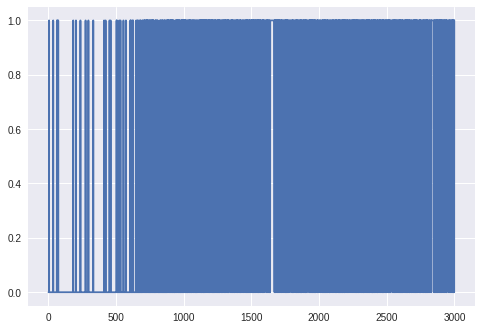

In [58]:
print("First with no eligibility traces!")
r,g = actor_critic(epochs=3000, useETforA=False, useETforC=False)

Now, with both eligibility traces!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


episode 200 Total reward achieved: 5 Efficiency 2.0 %
episode 400 Total reward achieved: 9 Efficiency 2.0 %
episode 600 Total reward achieved: 13 Efficiency 2.0 %
episode 800 Total reward achieved: 63 Efficiency 25.0 %
episode 1000 Total reward achieved: 209 Efficiency 73.0 %
episode 1200 Total reward achieved: 346 Efficiency 68.0 %
episode 1400 Total reward achieved: 476 Efficiency 65.0 %
episode 1600 Total reward achieved: 611 Efficiency 68.0 %
episode 1800 Total reward achieved: 752 Efficiency 70.0 %
episode 2000 Total reward achieved: 887 Efficiency 68.0 %
episode 2200 Total reward achieved: 1035 Efficiency 74.0 %
episode 2400 Total reward achieved: 1179 Efficiency 72.0 %
episode 2600 Total reward achieved: 1319 Efficiency 70.0 %
episode 2800 Total reward achieved: 1464 Efficiency 72.0 %
episode 3000 Total reward achieved: 1611 Efficiency 74.0 %


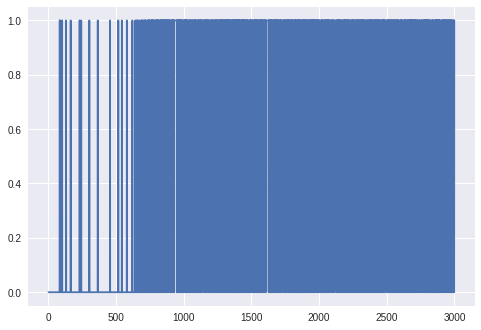

In [54]:
print("Now, with both eligibility traces!")
r,g = actor_critic(epochs=3000, useETforA=True, useETforC=True)

Now, with only critic eligibility traces!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


episode 200 Total reward achieved: 7 Efficiency 4.0 %
episode 400 Total reward achieved: 10 Efficiency 2.0 %
episode 600 Total reward achieved: 17 Efficiency 4.0 %
episode 800 Total reward achieved: 38 Efficiency 10.0 %
episode 1000 Total reward achieved: 134 Efficiency 48.0 %
episode 1200 Total reward achieved: 272 Efficiency 69.0 %
episode 1400 Total reward achieved: 409 Efficiency 68.0 %
episode 1600 Total reward achieved: 555 Efficiency 73.0 %
episode 1800 Total reward achieved: 701 Efficiency 73.0 %
episode 2000 Total reward achieved: 847 Efficiency 73.0 %
episode 2200 Total reward achieved: 1007 Efficiency 80.0 %
episode 2400 Total reward achieved: 1155 Efficiency 74.0 %
episode 2600 Total reward achieved: 1301 Efficiency 73.0 %
episode 2800 Total reward achieved: 1451 Efficiency 75.0 %
episode 3000 Total reward achieved: 1599 Efficiency 74.0 %


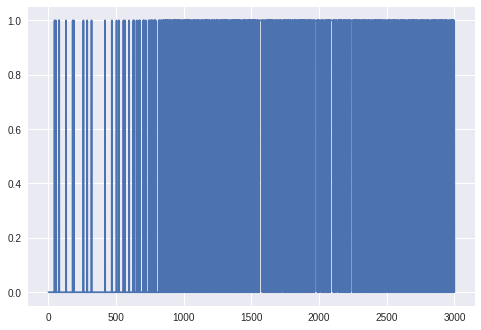

In [55]:
print("Now, with only critic eligibility traces!")
r, g = actor_critic(epochs=3000, useETforC=True)

## Effect of $\gamma$ and $\lambda$

Following are the results for effect of varying $\gamma$ and $\lambda$ on total reward obtained. 

The effect of these values can be easily seen in the plots below. In both cases a higher value seem to perform the best.  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


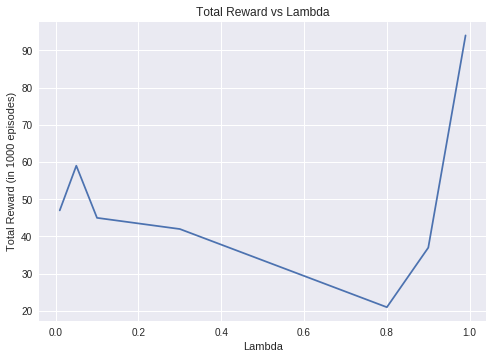

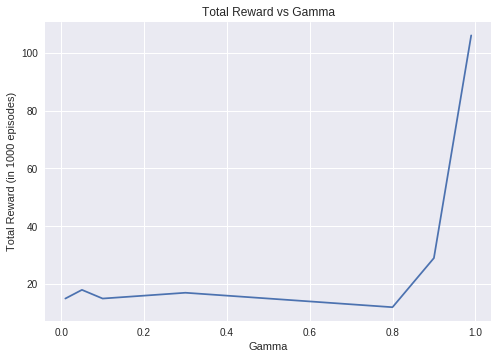

In [73]:
ltests = [0.01, 0.05, 0.1, 0.3, 0.8, 0.9, 0.99]
gtests = [0.01, 0.05, 0.1, 0.3, 0.8, 0.9, 0.99]
gResults = []
lRestults = []

for lamda in ltests:
    _, temp = actor_critic(epochs=1000, lamda=lamda, useETforC=True,verbose=False)
    lRestults.append(temp)
    
for gamma in gtests:
    _, temp = actor_critic(epochs=1000, gamma=gamma, useETforC=True,verbose=False)
    gResults.append(temp)
    
plt.plot(ltests, lRestults)
plt.title('Total Reward vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Total Reward (in 1000 episodes)')
plt.show()


plt.plot(gtests, gResults)
plt.title('Total Reward vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Total Reward (in 1000 episodes)')
plt.show()